In [1]:
import pandas as pd
import numpy as np
import random
from pprint import pprint
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
path = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/datamaps/test/datamap_test/roberta-large/random/42/confidences.pickle"
import pandas as pd
df2 = pd.read_pickle(path)
sample_ids = list(df2.keys())


cartography_dict = {}

for sample_id in sample_ids:
    
    times_correct = []
    confidences = []
    
    outputs = df2[sample_id]
    for output in outputs:
        
        # extract values from output tuple
        prediction = output[0]
        label = output[1]
        
        # obtain GT confidence, determine correctness of prediction
        confidence = prediction[label]
        correct = 1 if prediction.index(max(prediction)) == label else 0
        
        # track confidence and correctness
        confidences.append(confidence)
        times_correct.append(correct)
        
#     if np.std(confidences) != 0:
#             print(confidences)
    
    cartography_dict[sample_id] = {'confidence': np.mean(confidences),
                                  'variability': np.std(confidences),
                                  'correctness': np.mean(times_correct)}
    
    
#     print(sample_id, cartography_dict[sample_id])
        
        
    

confidences = [cartography_dict[key]['confidence'] for key in list(cartography_dict.keys())]
variability = [cartography_dict[key]['variability'] for key in list(cartography_dict.keys())]
correctness = [cartography_dict[key]['correctness'] for key in list(cartography_dict.keys())]

df = pd.DataFrame(list(zip(sample_ids, confidences, variability, correctness)), columns=['id', 'mean_conf', 'variability', 'correctness'])



In [3]:
def read_dataset(input_dir, dataset_id, split, seed, wanli_id):
    """
    This function takes a dataset id and reads the corresponding .json split in an appropriate Pandas DataFrame
    :param wanli_id: id key for wanli json file (pairID for metrics, id for non metric stuff)
    :param seed:
    :param input_dir:
    :param dataset_id: str indicating which dataset should be read
    :param split: str indicating which split should be read
    :return: DataFrame with examples (Premise, Hypothesis, Label, ID)
    """
    # anli_rounds = ['ANLI_R1', 'ANLI_R2', 'ANLI_R3']
    anli_rounds = ['ANLI_R2', 'ANLI_R3']

    def replace_labels(label):
        label_conversions = {'e': 'entailment',
                             'c': 'contradiction',
                             'n': 'neutral'}

        return label_conversions[label]

    if dataset_id == 'SNLI':

        # TODO only consider snli with gold labels?
        data_path = '{}/snli_1.0/snli_1.0_{}.jsonl'.format(input_dir, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'SNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)  # drop examples with no gold label

    # load separate ANLI rounds
    elif dataset_id in anli_rounds:

        data_round = dataset_id[-2:]  # extract the 'R#' substring from the provided ID
        data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
        dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
        dataset['dataset'] = 'ANLI_{}'.format(data_round)
        #
        # print('Dataframe for {} - {}'.format(dataset_id, split), flush=True)

    # compile all ANLI rounds
    elif dataset_id == 'ANLI':

        dataset_list = []
        for data_round in anli_rounds:
            data_round = data_round[-2:]
            data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
            dataset = pd.read_json(data_path, lines=True)
            dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
            dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
            dataset['dataset'] = 'ANLI'
            dataset_list.append(dataset)
        dataset = pd.concat(dataset_list, axis=0)

    # Load MNLI
    elif dataset_id == 'MNLI':

        if split == 'train':
            data_path = '{}/multinli_1.0/multinli_1.0_{}.jsonl'.format(input_dir, split)
        elif split == 'dev' or split == 'test':
            data_path = '{}/multinli_1.0/multinli_1.0_dev_matched.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'MNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset)/2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset)/2)):]

    # Load WANLI
    elif dataset_id == 'WANLI':

        if split == 'train':
            data_path = '{}/wanli/train.jsonl'.format(input_dir)
        elif split == 'dev' or split == 'test':
            data_path = '{}/wanli/test.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['premise', 'hypothesis', 'gold', wanli_id]]
        dataset['dataset'] = 'WANLI'
        dataset = dataset.drop(dataset[dataset.gold.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset) / 2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset) / 2)):]

    else:
        raise KeyError('No dataset found for "{}"'.format(dataset_id))

    # ensure consistent headers per dataset DataFrame
    dataset.columns = ['Premise', 'Hypothesis', 'Label', 'ID', 'Dataset']

    dataset['ID'] = dataset['ID'].astype('string')

    return dataset



In [4]:
INPUT_DIR='/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/resources/ard_data'
SPLIT='train'
SEED=42
WANLI_ID='pairID'

def read_source(dataset_id):
    dataset = read_dataset(input_dir=INPUT_DIR, 
                 dataset_id=dataset_id, 
                 split=SPLIT, 
                 seed=SEED, 
                 wanli_id=WANLI_ID)
    return dataset

In [58]:
snli = read_source('SNLI')
anli = read_source('ANLI')
wanli = read_source('WANLI')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


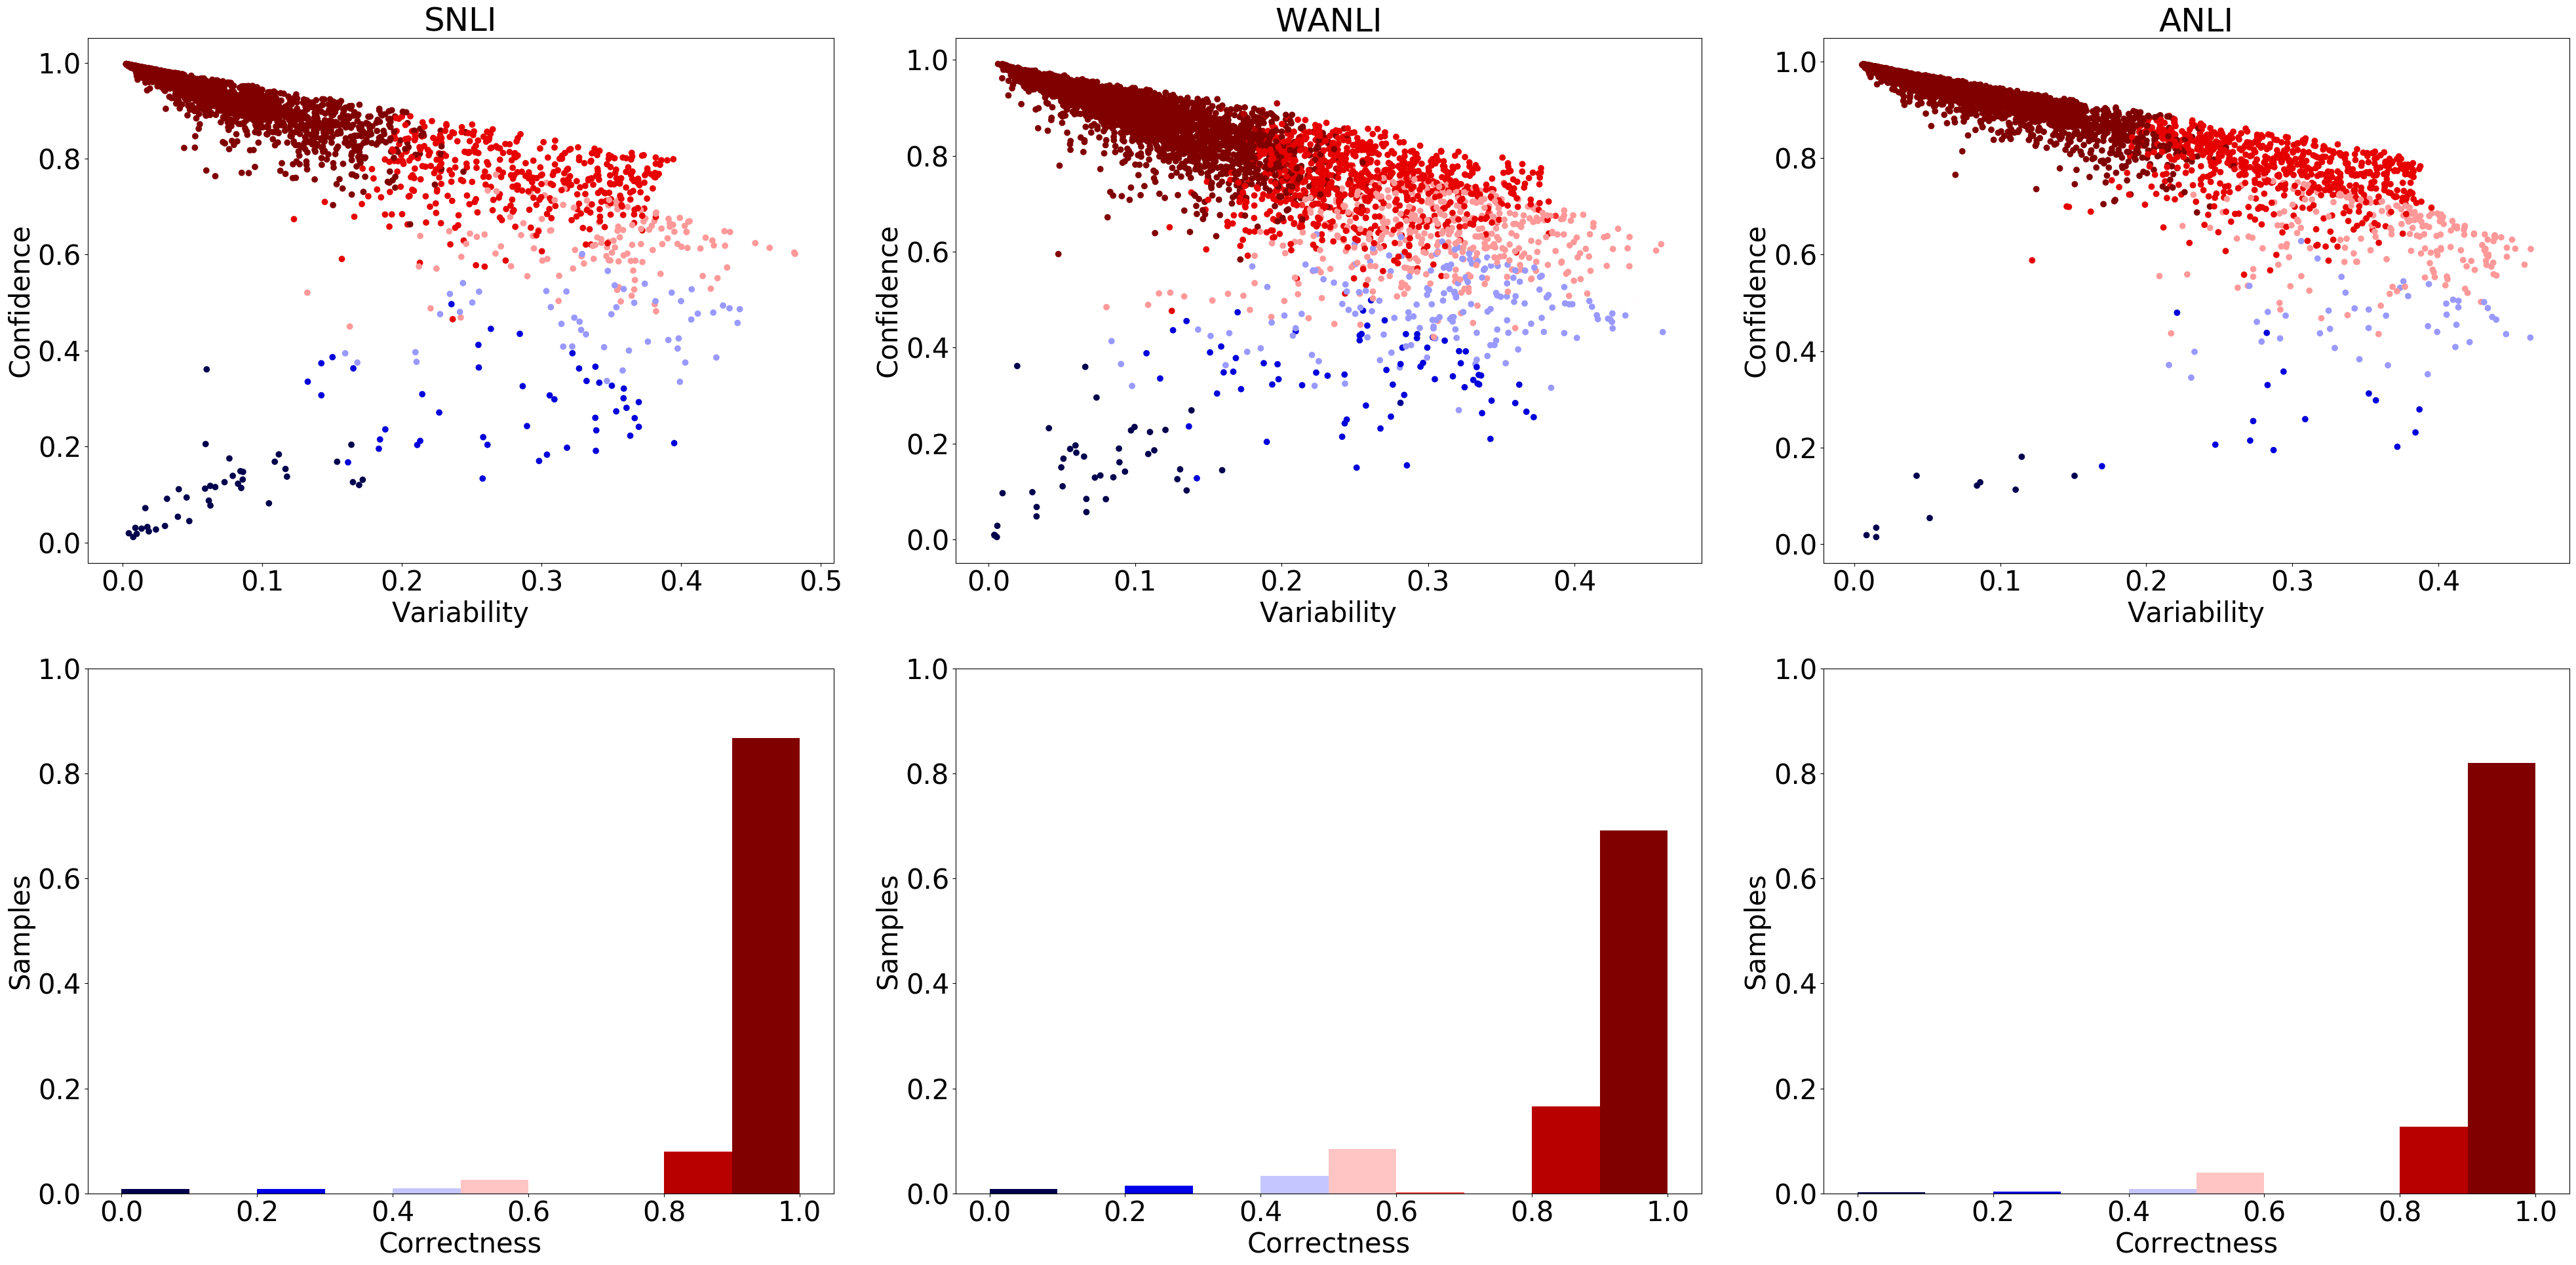

In [243]:
from matplotlib.ticker import PercentFormatter

def generate_df(dataframe):
    X = dataframe['variability'].tolist()
    Y = dataframe['mean_conf'].tolist()
    colors = dataframe['correctness'].tolist()

    plt.figure(figsize=(10, 10))
    plt.scatter(x=X, y=Y, c=colors, alpha=1, cmap=plt.cm.seismic)
    plt.xlim(0,0.5)
    plt.ylim(0,1)
    plt.xlabel('Variability')
    plt.ylabel('Confidence')
    plt.legend()
    plt.show()
    
def generate_dfs(dataframe_list):
    
    figure, axis = plt.subplots(nrows=2, 
                                ncols=len(dataframe_list), 
                                figsize=(40, 20))
#                                 sharey='row')
    
    for i, dataframe in enumerate(dataframe_list):
        
        X = dataframe['variability'].tolist()
        Y = dataframe['mean_conf'].tolist()
        colors = dataframe['correctness'].tolist()
        
        axis[0, i].scatter(x=X, y=Y, c=colors, alpha=1, cmap=plt.cm.seismic)
        axis[0, i].set_title(dataframe.Name.tolist()[0])
        
        axis[0, i].set_xlabel('Variability')
        axis[0, i].set_ylabel('Confidence')
        
#     figure.suptitle('Source datamaps')
    plt.rcParams.update({'font.size': 30})
    
    
    for i, dataframe in enumerate(dataframe_list):
        
        X = dataframe['variability'].tolist()
        Y = dataframe['mean_conf'].tolist()
        correctness = dataframe['correctness'].tolist()
        
        # This is  the colormap I'd like to use.
        cm = plt.cm.seismic

        # Plot histogram.        
        n, bins, patches = axis[1, i].hist(correctness, 
                                           10, 
                                           weights=np.ones(len(correctness)) / len(correctness), 
                                           density=False, 
                                           color='green')
        
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # scale values to interval [0,1]
        col = bin_centers - min(bin_centers)
        col /= max(col)

        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c))
            
#         heights = n.tolist()
#         percentages = [(height/sum(heights)*100) for height in heights]
#         axis[1, i].set_yticklabels(['{}%'.format(percentage) for percentage in percentages])

        axis[1, i].set_xlabel('Correctness')
        axis[1, i].set_ylabel('Samples')
        
        axis[1, i].set_ylim(0,1)
    
    plt.tight_layout()
    plt.show()
    

def generate_strategy_map(base_df, strategy):
    path = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/acquisition_IDs/array/OOD_MNLI_active_learning_array_donderdag/roberta-large/{}/42/acquisition_ids.csv".format(strategy)
    acquired_df = pd.read_csv(path)

    ids = acquired_df.ID[:4000]

    acquired_df = base_df[base_df.id.astype('string').isin(ids)]
    generate_df(acquired_df)
    
def datamap_subset(base_df, source_df):
    
    source_ids = source_df.ID
    
    subset_df = base_df[base_df.id.astype('string').isin(source_ids)]
    subset_df['Name'] = source_df.Dataset.tolist()[0]
    
    return subset_df

snli_map = datamap_subset(base_df=df, source_df=snli)
anli_map = datamap_subset(base_df=df, source_df=anli)
wanli_map = datamap_subset(base_df=df, source_df=wanli)

df_list = [snli_map,
          wanli_map,
          anli_map]
generate_dfs(df_list)

plt.rcParams['figure.dpi'] = 100

In [158]:
def generate_source_map(base_df, source_df):

    ids = source_df.ID

    source_df = base_df[base_df.id.astype('string').isin(ids)]
    
    print('num of source in base: {}'.format(len(source_df)))
    
    generate_df(source_df)

In [ ]:
# snli = read_source('SNLI')
anli = read_source('ANLI')

In [ ]:
wanli = read_source('WANLI')

In [ ]:
# generate_source_map(base_df=df,
#                     source_df=snli)

generate_df(df)

In [ ]:
generate_strategy_map(base_df=df, strategy='bald')

In [ ]:
generate_strategy_map(base_df=df, strategy='random')

In [ ]:
generate_strategy_map(base_df=df, strategy='max-entropy')

In [ ]:
generate_strategy_map(base_df=df, strategy='mc-max-entropy')

In [ ]:
generate_strategy_map(base_df=df, strategy='dal')